# **L01: Partial Dependency and Individual Conditional Expectation Plots**

<img src="./static/LO1.png" alt="LO1 Image" style="width: 50%; height: auto;">

## Overview

In this notebook, you will explore the **utility and limitations** of Partial Dependency (PDP) and Individual Conditional Expectation (ICE) plots. You will work with **two dataset-model pairs**:

1. **Bike Rental Dataset (bike_sharing_data.csv) & Model (bike_sharing_model.pkl)**  
   - This dataset includes four features: `temp`, `feel_temp`, `humidity`, and `windspeed`.  
   - Each feature influences the number of bike rentals differently.  
   - In **Section 1**, you will **manually replicate PDP and ICE plots** from `sklearn` to understand these concepts deeply.

2. **Mystery Dataset (mystery_data.csv) & Model (mystery_model.pkl)**  
   - This dataset contains **only two binary features** (`Feature1`, `Feature2`).  
   - The corresponding model achieves **100% classification accuracy**.  
   - In **Section 2**, you will analyze this dataset to **uncover the model's decision rule**.

---

## **Section 1 | Understanding PDP and ICE Curves**
Replicate `sklearn`'s PDP and ICE plots using your own code.

### **Tasks:**
- **1.1** | Manually compute and plot the **PDP curve** for the target feature `temp`.
- **1.2** | Manually compute and plot the **ICE curves** for `temp`.
- **1.3** | **Center** the ICE curves and plot them along with their average.
- **1.4** | **Discuss** your results and insights.

---

## **Section 2 | Deciphering the Mystery Model**
Analyze the PDP and ICE plots to determine the decision-making process of the mystery model.

### **Tasks:**
- **2.1** | Plot the **PDP and ICE curves** for both `Feature1` and `Feature2`.
- **2.2** | **Analyze and discuss** the results. If the model’s decision rule remains unclear, provide a logical argument supporting your findings.

---

By the end of this notebook, you should have a strong understanding of how PDP and ICE plots provide insights into model behavior and their limitations in different contexts.

Import necessary libraries

In [2]:
import joblib # for saving and loading models from sklearn
import numpy as np # for numerical computation
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for data visualization
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay # for displaying partial dependence plots and individual conditional expectation
import warnings # filter warnings
warnings.filterwarnings("ignore")

Import the model and data

In [3]:
model = joblib.load('../models/bike_sharing_model.pkl')
data = pd.read_csv('../data/bike_sharing_data.csv')

Use sklearn's built-in function to plot the ICE and PDP

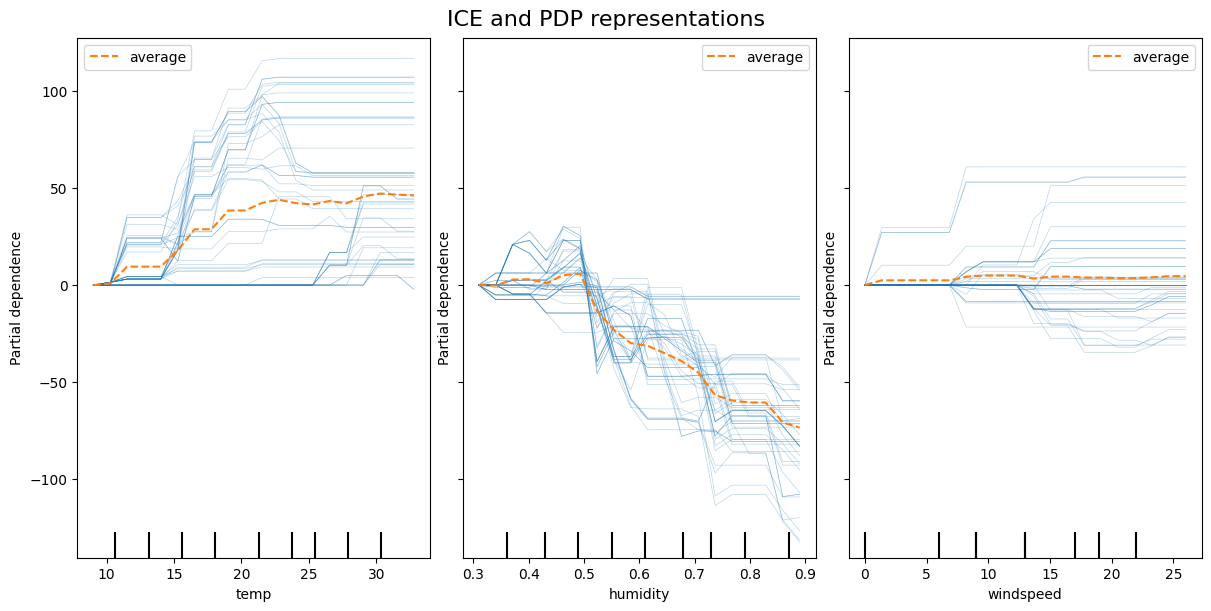

In [4]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 6), sharey=True, constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    model, # Pre-trained gradient boosed regressor tree model
    data, # Data to plot
    features=["temp", "humidity", "windspeed"], # Features to plot from the dataframe
    kind="both",  # This will plot both PDP and ICE
    centered=True, # Center the ICE curves becaue we are only interested in the shape of the curve not the absolute values
    subsample=50, # Subsample the data to speed up the plotting, we only plot 50 instances
    n_jobs=2, # Use 2 cores to speed up the computation
    grid_resolution=20, # Number of points in the grid, the higher the better the resolution
    random_state=0, # Set the random state for reproducibility
    ax=ax) # Plot the ICE and PDP on the same axis
display.figure_.suptitle("ICE and PDP representations", fontsize=16) # Set the title of the plot
plt.show() # Show the plot
plt.close() # Close the plot to free up memory

### Section 1 | Understand PDP and ICE curves by replicating sklearn plots with your own code


Using your theoretical knowledge from LO1, your task is to manually calculate both the PDP and ICE curves. For this, you will only require the **model** and **data** loaded above. The data is stored in a pandas dataframe, and the model is a pre-trained tree regression model. You can view the dataframe's first few entries using the method `data.head()`. Remember to vectorize your code; you should only ever require a single for loop and never a nested loop.

**1.1 | Manually compute the PDP curve for the target feature "temp" and plot the result**

Remember: The PDP formula, $f_{PDP}^p(x^p) = \mathbb{E}_{X_{-p}}[f(x^1, x^2, \ldots, x^p, \ldots, x^k)]$, calculates the marginal effect of the feature $x^p$ on the predicted outcome by averaging the predictions of the function $f$ over the joint distribution of all other features $X_{-p}$. Remember to sort the dataset according to the temp value before calculating and plotting.

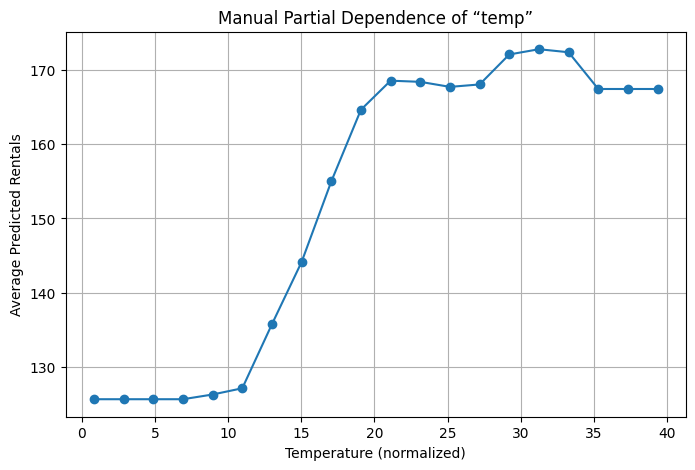

In [5]:
# YOUR CODE HERE
# 1. Define a grid of temp values (sorted)
temp_grid = np.linspace(data['temp'].min(),
                        data['temp'].max(),
                        num=20)

# 2. For each temp value, overwrite the column and predict
pdp_values = []
for t in temp_grid:
    # copy the dataset, set all temps to t
    df_temp = data.copy()
    df_temp['temp'] = t
    
    # predict and average
    preds = model.predict(df_temp)
    pdp_values.append(preds.mean())

# 3. Plot the manual PDP
plt.figure(figsize=(8, 5))
plt.plot(temp_grid, pdp_values, marker='o', linestyle='-')
plt.xlabel('Temperature (normalized)')
plt.ylabel('Average Predicted Rentals')
plt.title('Manual Partial Dependence of “temp”')
plt.grid(True)
plt.show()

***1.2 | Manually compute the ICE curves for the target feature of temp and plot the results***

Remember, a single ICE curve consists of the model predictions over a fixed instance while varying the feature of interest. It is extremely computationally expensive to calculate ICE curves for all instances, therefore randomly sample and plot the ICEs of 50 instances only.

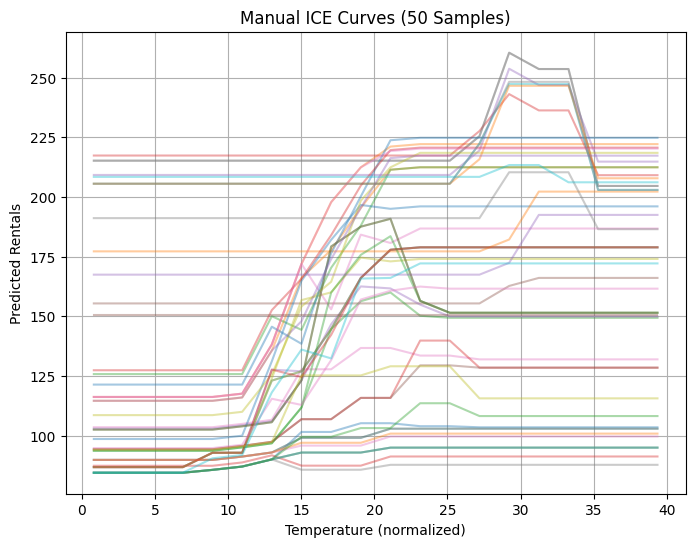

In [6]:
# YOUR CODE HERE

# 1. Sample 50 instances at random
ice_data = data.sample(n=50, random_state=42).reset_index(drop=True)

# 2. Prepare a matrix to hold predictions: rows=instances, cols=grid points
ice_matrix = np.zeros((len(ice_data), len(temp_grid)))

# 3. For each temp in the grid, overwrite and predict all 50 at once
for j, t in enumerate(temp_grid):
    X_temp = ice_data.copy()
    X_temp['temp'] = t
    ice_matrix[:, j] = model.predict(X_temp)

# 4. Plot each instance’s curve
plt.figure(figsize=(8, 6))
for i in range(ice_matrix.shape[0]):
    plt.plot(temp_grid, ice_matrix[i, :], alpha=0.4)
plt.xlabel('Temperature (normalized)')
plt.ylabel('Predicted Rentals')
plt.title('Manual ICE Curves (50 Samples)')
plt.grid(True)
plt.show()

***1.3 | Center the ICE curves and plot the results as well as the average on the same axes***

It is often difficult to interpret ICEs because the plot is unorderly. Since we are only interested in trends and not absolute values, i.e., does the predicted target increase, decrease, or remain the same as we vary the input. One way to center the ICE is to subtract a constant baseline. Selecting the baseline as the predicted value when selecting the anchor as the smallest feature value will ensure all ICE curves start from zero.

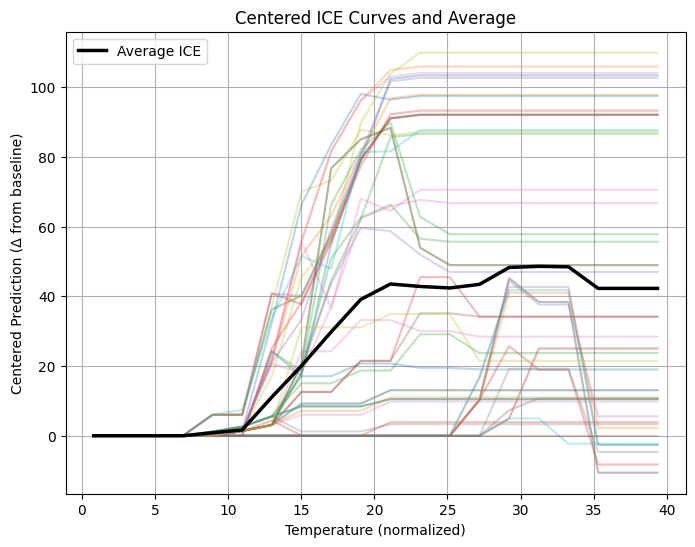

In [7]:
# YOUR CODE HERE


# 1. Compute baselines: the prediction at the smallest temp (first column)
baseline = ice_matrix[:, 0]  # shape (50,)

# 2. Center each ICE curve by subtracting its baseline
centered_ice = ice_matrix - baseline[:, np.newaxis]  # broadcast subtraction

# 3. Compute the average centered ICE across instances
mean_centered = centered_ice.mean(axis=0)

# 4. Plot all centered ICEs
plt.figure(figsize=(8, 6))
for i in range(centered_ice.shape[0]):
    plt.plot(temp_grid, centered_ice[i, :], alpha=0.3)

# 5. Overlay the average curve
plt.plot(temp_grid, mean_centered, linewidth=2.5, label='Average ICE', color='black')

plt.xlabel('Temperature (normalized)')
plt.ylabel('Centered Prediction (Δ from baseline)')
plt.title('Centered ICE Curves and Average')
plt.legend()
plt.grid(True)
plt.show()

***1.4 | Discuss your results***

1. What the PDP Shows
    - When you look at the PDP line, it stays almost flat at low temperatures, then climbs quickly in the middle range, and finally levels off at higher temperatures.
    - In simple terms: on average, very cold days don’t get many rentals, as it warms up rentals jump a lot, and after it gets really hot, rentals don’t increase much more.

2. What the ICE Curves Show
    - Each colored line is one day’s prediction as we change temperature. Most lines follow the same “flat → steep rise → plateau” shape, but they don’t all match exactly.
    - A few days actually dip at the highest temperatures—maybe because those days were also very windy or humid.

3. Why We Center the ICE Curves
    - By subtracting each day’s prediction at the lowest temperature, all curves start at zero. This makes it easier to see each day’s change from “cold” to “hot.”
    - When you draw the average of these centered curves (the thick black line), it looks almost the same as the PDP. That’s because PDP is just the average of all those individual lines.

**Summary:**
- Average vs. Individual: The PDP gives you one smooth “average” story, but ICE shows you each day’s unique response.
- Hidden Details: If you only rely on the PDP, you might miss that some days behave differently because of other weather factors.
- Centering ICE: Shifting all lines to start at zero makes it much easier to compare how big each day’s change really is.
- Good Practice: Always peek at a few ICE curves (or use centered ICE) alongside the PDP so you don’t get fooled by the average.

### Section 2 | Try and determine what rule the mystery model is using for its predictions on the mystery dataset

***2.1 | Plot the PDP and ICE curves for both "Feature1" and "Feature2"***

In [8]:
# Import mystery data and model
X = pd.read_csv('../data/mystery_data.csv')
model = joblib.load('../models/mystery_model.pkl')
X.head()

,Feature1,Feature2
0,1,1
1,1,1
2,1,1
3,1,0
4,0,1


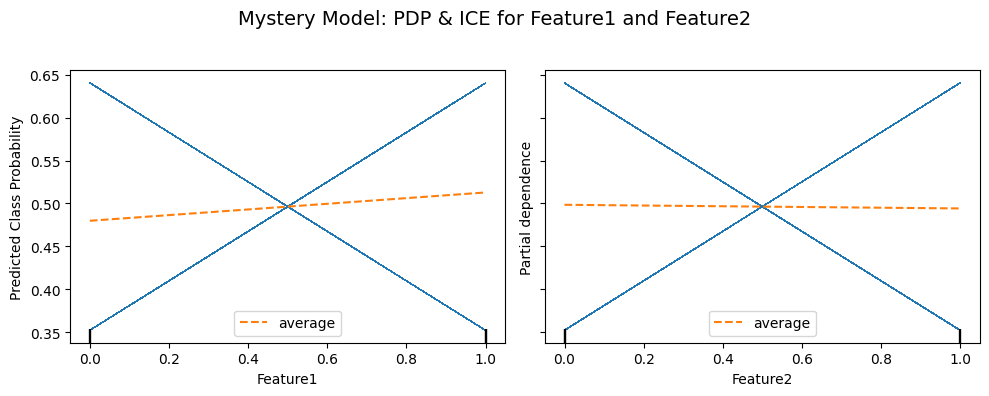

In [9]:
# YOUR CODE HERE

# 1. Define the two features we care about
features = ["Feature1", "Feature2"]

# 2. Create side‑by‑side plots
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# 3. Plot PDP (average) and ICE (individual) for both features
PartialDependenceDisplay.from_estimator(
    model,
    X,
    features=features,
    kind="both",          # show PDP and ICE
    grid_resolution=2,    # only values 0 and 1
    subsample= X.shape[0],# use all rows (dataset is small)
    random_state=0,       # for reproducibility of ICE ordering
    ax=axes
)

# 4. Tidy up
fig.suptitle("Mystery Model: PDP & ICE for Feature1 and Feature2", fontsize=14)
for ax, feat in zip(axes, features):
    ax.set_xlabel(feat)
axes[0].set_ylabel("Predicted Class Probability")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

***2.2 | Analyze and discuss the results. If you cannot explain the model's decisions, then argue your point.***

1. The average hides everything
    - If you only look at the dashed “average” line on each plot, it stays right around 0.5. That makes it look like changing Feature1 or Feature2 does nothing overall.
    - But averages can hide important details.
  
2. Each line tells a different story
    - The solid lines (one per data point) split into two groups:
    - Some go up when you switch the feature from 0→1 (meaning the model is more likely to predict “1” then).
    - Some go down when you switch from 0→1 (meaning the model is more likely to predict “0” then).
    - Which group a line falls into depends on the other feature’s value.

3. It’s the XOR rule
    - This pattern—half the lines going up, half going down—is exactly what you’d see if the model is doing an exclusive‑or (XOR) check:
    - If Feature1 and Feature2 are different (one is 0, the other is 1), the model predicts 1.
    - If they are the same (both 0 or both 1), the model predicts 0.
    - Since the model is 100% accurate on your data, it has perfectly learned that “predict 1 when the two features differ, otherwise predict 0.”


**Summary:** Even though the average effect is flat, looking at each individual line reveals the model is using an XOR rule on Feature1 and Feature2.

# **L01: Shapley Values (Theory and Application)**

<img src="./static/SHAP.png" width="1500" alt="Shapley Values Visualization">

## **Introduction**
In this notebook, you will test both your **theoretical understanding** of Shapley values and your ability to **interpret their results**. 

- The first task will help you understand the **fundamental equation** behind Shapley values:

  $$
  \phi_i(x) = \sum_{S \subseteq N \backslash \{i\}} \frac{|S|! \times (|N| - |S| - 1)!}{|N|!} \left(f_\theta(S \cup \{i\}) - f_\theta(S)\right)
  $$

  You will explore how Shapley values are **computed** and why they are computationally expensive.  
- You will then implement your own **approximate** solution to the Shapley value problem.  
- Finally, you will use the **SHAP library** to interpret model predictions.

---

## **Using the SHAP Library**
You will use the [SHAP library](https://shap.readthedocs.io/en/latest/index.html) to analyze and interpret predictions from two models.

- The library includes **fast approximate methods** such as **KernelSHAP** and **TreeSHAP**.
- It also provides **built-in visualizations** to analyze SHAP values, including:
  - **Summary/Beeswarm Plots**
  - **Dependence Plots**
  - **Force Plots**
  - **Waterfall Plots**

These visualizations allow you to:
- **Understand the impact** of each feature on the model's predictions.
- Analyze explanations at **both local (per-instance) and global (dataset-wide) levels**.

---

## **Datasets and Models**
You will work with **two dataset-model pairs**:

1. **Titanic Dataset**  
   - Dataset: `titanic_data.csv`  
   - Model: `titanic_model.pkl`  
   - A tree ensemble model trained to **predict passenger survival** on the Titanic.

2. **Mystery Dataset**  
   - Dataset: `mystery_data.csv`  
   - Model: `mystery_model.pkl`  
   - The same dataset and model from the previous exercise.
   - You will use SHAP to **validate or refine** your previous arguments about the model’s decision-making process.

**Note:** The datasets **do not include target values**, but they were used to train the models.

---

## **Section 1 | Understanding the Normalization Factor in Shapley Value Calculation**
Learn how Shapley values are weighted and why this is necessary.

### **Tasks:**
- **1.1** | Implement a function to compute the weighting factor:  
  $$\frac{|S|! \times (|N| - |S| - 1)!}{|N|!}$$  
  - The function should take two arguments: `shapley_weight_factor(n, s)`, where `n` is the total number of features, and `s` is the subset size.
- **1.2** | Sum the values of all possible coalitions and print the result.
- **1.3** | Plot the **number of coalitions** as a function of subset size $|S|$, along with the **associated weight factor**.
- **1.4** | Explain why weighting is necessary.  
  - What kind of bias could occur if we didn’t apply these weights?

---

## **Section 2 | Calculating Shapley Values Using Monte Carlo Approximation**
Explore the computational complexity of exact Shapley values and implement an approximation.

### **Tasks:**
- **2.1** | Compute the number of evaluations required to calculate **exact** Shapley values for a single feature of a single instance.  
  - Provide your reasoning for **$n=4$** features.
- **2.2** | Implement a **Monte Carlo approximation** for computing Shapley values.

---

## **Section 3 | Using the SHAP Library to Analyze the Titanic Dataset**
Use SHAP to interpret model predictions and compare different explanation methods.

### **Tasks:**
- **3.1** | Use SHAP to calculate the **Shapley values** for all features and instances in the Titanic dataset.
- **3.2** | **Rank feature importance**, visualize the results, and discuss key takeaways.
- **3.3** | Compare a **PDP plot** for `Age` with a **SHAP dependence plot**.  
  - What additional insights does SHAP provide?
- **3.4** | Create a **SHAP feature dependence plot** for `Age`, including an **interaction visualization** with `Sex`.  
  - Interpret the results.
- **3.5** | **Remove individual effects** and plot only the **pure interaction** between `Age` and `Class`.
- **3.6** | **Local Shapley explanations**:  
  - Select specific instances and analyze their explanations.

---

## **Section 4 | Determining the Decision-Making Process of the Mystery Model**
Use SHAP to analyze how the mystery model makes decisions.

- Apply SHAP techniques to explain the predictions.
- Compare insights with your findings from the previous exercise.
- Discuss any new patterns or contradictions revealed by SHAP.

---

By the end of this notebook, you should have a **deep understanding** of Shapley values, their computational challenges, and how the SHAP library can be used to explain model decisions effectively.

Import necessary libraries

In [10]:
import shap # for calculating Shapley values using the SHAP library
import joblib # for saving and loading models from sklearn
import random # for generating random numbers
import numpy as np # for numerical operations
import pandas as pd # for tabular data manipulation
import xgboost as xgb # for training the XGBoost model
from math import factorial # for calculating the number of combinations
import matplotlib.pyplot as plt # for plotting
from itertools import combinations # for generating all possible combinations
import warnings
warnings.filterwarnings('ignore')
shap.initjs() # Visualize the SHAP values for the instance
# Create a color map
from matplotlib.colors import LinearSegmentedColormap
color_high = 'sandybrown'  # Color for high feature values
color_low = 'skyblue' # Color for low feature values
cmap = LinearSegmentedColormap.from_list("custom_cmap", [color_low, color_high])

### **Section 1 | Understanding the Normalization Factor in Shapley Value Calculation**    

The image below illustrates a model with **four hypothetical features** as inputs. These features could represent factors such as **class attendance, pre-exam results, hours of self-study, and age** in a regression model trained to predict **final exam results**.

To compute **Shapley values**, we evaluate the model's output across **all possible coalitions of features**, summing the contributions while applying a **normalization factor**. This factor ensures that each coalition is weighted appropriately based on the number of features and subset size.

The image below specifically shows **all possible coalitions** when calculating the contribution of the **star-shaped feature** to the model's output:

<img src="./static/shapley_weights.png" width="500" alt="Shapley Weights Visualization">

In the following tasks, you will:
- **Examine the normalization factor** used in Shapley value calculations.
- **Analyze how it scales** with the total number of features and subset sizes.
- **Understand why normalization is necessary** to fairly distribute feature contributions.

**1.1 | Create a function in Python to calculate the weighting factor $\frac{|S|! \times (|N| - |S| - 1)!}{|N|!}$ in the Shapley value formula above. The function should take in two arguments, i.e., `shapley_weight_factor(n, s)` where $n$ is the total number of features and $s$ is the size of the subset. The function should output the weight assigned to each coalition of size $|S|$.**

In [11]:
def shapley_weight_factor(n, s):
    """
    Calculate the Shapley weight factor for a subset of size s with total n features.
    """
    # YOUR CODE HERE
    weight = (factorial(s) * factorial(n - s - 1)) / factorial(n)
    return weight

***1.2 | Use the function to sum the values of all possible coalitions and print your result.***

In [12]:
# YOUR CODE HERE

# Total number of features
n = 4

# Sum over all subsets S (of size s = 0 to n-1)
total_weight = 0.0
for s in range(n):
    # number of ways to choose s features out of the other (n−1)
    num_subsets = factorial(n - 1) // (factorial(s) * factorial((n - 1) - s))
    
    # weight for each coalition of size s
    w = shapley_weight_factor(n, s)
    
    # accumulate
    total_weight += num_subsets * w

print(f"Sum of all Shapley weights (n={n}): {total_weight:.3f}")

Sum of all Shapley weights (n=4): 1.000


**1.3 | Plot the number of combinations/coalitions as a function of subset size $|S|$. On the same axis, include a plot of the associated weight factor for each subset.**

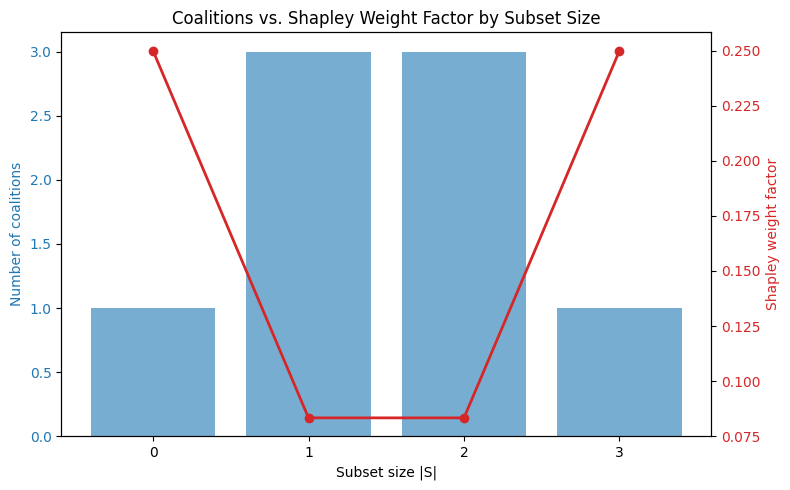

In [13]:
# YOUR CODE HERE

 # Subset sizes S = 0, 1, ..., n-1
subset_sizes = list(range(n))

# Compute number of coalitions for each subset size
num_coalitions = [
    factorial(n - 1) // (factorial(s) * factorial((n - 1) - s))
    for s in subset_sizes
]

# Compute Shapley weight factor for each subset size
weight_factors = [shapley_weight_factor(n, s) for s in subset_sizes]

# Create the plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Bar plot for number of coalitions on primary y-axis
ax1.bar(subset_sizes, num_coalitions, alpha=0.6)
ax1.set_xlabel('Subset size |S|')
ax1.set_ylabel('Number of coalitions', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Line plot for weight factor on same axis (secondary y-axis)
ax2 = ax1.twinx()
ax2.plot(subset_sizes, weight_factors, marker='o', linewidth=2, color='tab:red')
ax2.set_ylabel('Shapley weight factor', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Titles and ticks
plt.title('Coalitions vs. Shapley Weight Factor by Subset Size')
plt.xticks(subset_sizes)
plt.grid(False)
plt.tight_layout()
plt.show()

***1.4 | Explain why the weighting factor is necessary. Think about what kind of bias we could expect if we did not weight the values.***

- Problem without weights:
    - There are lots of ways to pick “medium-sized” groups of features (for example, choosing 1 or 2 out of 4).
    - If we just averaged all groups equally, the model’s behavior in those medium-size groups would count way more than its behavior in the very small or very large groups.
    - That would make our final answer mostly reflect what happens in the “typical” cases and ignore the rarer ones.
- How weights help:
    - We give each group-size the same overall influence by:
        - Giving each medium-size group a smaller per-group weight (because there are many of them), and
        - Giving each rare, small or large group a bigger per-group weight (because there are fewer of them).
    - This way, all possible “contexts” (from no other features to all the other features) count fairly when we decide how much each feature really contributes.

**Summary:** The weights make sure we’re not accidentally favoring the _most common_ feature-combinations—and instead truly average the feature’s impact over **every** possible situation.

## **Section 2 | Calculating Shapley Values Using Monte Carlo Approximation**

Shapley values provide an **ideal approach** for model explanations, but computing them exactly is often impractical due to two main challenges:

1. **Computational Cost**
   - The number of possible feature coalitions grows **exponentially** with the total number of features $n$.  
   - This makes exact Shapley value calculations infeasible for **high-dimensional data** such as images, text, or large tabular datasets.  
   
2. **Handling Missing Features in ML Models**
   - Shapley values require computing the model's output across all subsets of features.  
   - However, most ML models expect a fixed number of inputs and cannot process missing features directly.  
   - To address this, we introduce the concept of a **baseline**.

---

### **What is a Baseline?**
A **baseline** is a reference value that represents **"missingness"**, allowing us to turn features on and off while keeping the input dimensions consistent. 

A poorly chosen baseline can **misrepresent feature attributions**, so the choice of baseline must be made **carefully**.

### **Monte Carlo Approximation for Shapley Values**
Monte Carlo approximation provides an efficient alternative to exact Shapley value computation by **randomly sampling feature coalitions** instead of iterating over all possible subsets.

**How does it work?**
1. Instead of removing a feature directly, we replace it with a **baseline value**.
2. A common (but flawed) approach is to replace feature values with random noise sampled from a normal distribution:  
   $$ q \sim \mathcal{N}(\mu, \sigma^2) $$
   However, this method **alters the model's predictions** unpredictably:
   - $f_\theta(x_{j\to q_1}) \neq f_\theta(x_{j\to q_2})$, meaning the model reacts differently each time.
   - The feature dependencies are ignored, leading to **unrealistic inputs**.
   - The generated samples may fall **outside the training distribution**.

3. A **better approach** is to sample feature values **from real data points** instead of random noise.  
   - This ensures that feature correlations are preserved.  
   - It helps maintain **realistic** model inputs while simulating missing features.  

---

### **Why is This Important?**
Understanding baselines is **critical** for Shapley value calculations and will be a key topic in this course.  
- A **baseline** should be carefully chosen to accurately reflect **feature absence**.
- Monte Carlo approximation allows us to **efficiently estimate** Shapley values by sampling from real data rather than computing all possible subsets.

**Next Steps**: You will now implement Monte Carlo-based Shapley value estimation and compare it to exact calculations.

**2.1 | If we want to calculate the Shapley values exactly for a single feature of a single instance/row, how many calculations have to be performed? Provide your reasoning and answer for the case of $n=4$ features.**

- You have 4 total features. Pick one target feature “i” whose Shapley value you want.
- You must consider every possible subset S of the other features (so S can be size 0,1,2,3).
- There are such subsets:

$$ \sum_{s=0}^{3} \binom{3}{s} \;=\; 2^3 \;=\; 8 $$

- For each subset S you need two model evaluations:
	1. $ f(S \cup \{i\}) $ (feature $i$ present)
	2. $ f(S) $ (feature $i$ absent, replaced by baseline)
- Total model calls = $8 \times 2 = 16$.

So, to get the exact Shapley value for one feature when n=4, you’d make 16 separate predictions.

**2.2 | Approximate Calculation of Shapley Values Using Monte Carlo** 

If the number of calculations necessary for a single Shapley value scales exponentially with the number of features, we require approximate methods. Code your own version of the Monte Carlo approximation, as discussed in the summary materials, to estimate the Shapley values of all four features for a single instance of the "bike_sharing_data" dataset and "bike_sharing_model" model. Compare your result with the output generated by the SHAP library.

Follow these steps:

1. Create a function that Implements the Monte Carlo approximation to estimate Shapley values.
2. Apply your implementation to estimate the Shapley values for all four features of a single instance from the "bike_sharing_data" dataset.
3. Compare your estimated Shapley values with those produced by the SHAP library.
4. Experiment with different numbers of Monte Carlo samples. Increase or decrease the number of samples and observe the changes in the estimated Shapley values.
5. Interpret your results, considering how the number of Monte Carlo samples affects the accuracy and stability of the Shapley value estimates.

By completing this exercise, you will gain an understanding of how the Monte Carlo approximation works, and how the effectiveness of baslines depends on the number of samples.

<img src="./static/shapley_monte_carlo.png" width="1000" alt="image description">

In [14]:
# Load the model and data
model = joblib.load('../models/bike_sharing_model.pkl')

# Load the data
data = pd.read_csv('../data/bike_sharing_data.csv')

data.head()

,temp,feel_temp,humidity,windspeed
0,14.76,18.940,0.66,0.0000
1,11.48,14.395,0.81,7.0015
2,12.30,15.910,0.81,7.0015
3,18.86,22.725,0.51,19.9995
4,18.04,21.970,0.62,19.9995


In [15]:
# Your function for implementing the Monte Carlo approximation

def monte_carlo_shapley_values(data: pd.DataFrame, model: object, M: int, sample_idx: int) -> list:
    """
    Calculate the Shapley values for all features using the Monte Carlo approximation.
    Parameters:
    data (pd.DataFrame): The dataset.
    model (sklearn-like model): The model to evaluate.
    M (int): The number of Monte Carlo simulations (evaluated coalitions).
    Returns:
    list: Shapley values for each feature.
    """
    shapley_feature_values = []  # Initialize the list to store the Shapley values
    x = data.iloc[sample_idx].copy() # Extract the instance to explain
    n_features = data.shape[1]  # Number of features
    cols = data.columns.tolist()


    # YOUR CODE HERE
    baseline = data.mean()
    phi = np.zeros(n_features)
    for _ in range(M):
        perm = np.random.permutation(n_features)
        S = []
        for idx in perm:
            x_S = baseline.copy()
            if S:
                x_S.iloc[S] = x.iloc[S]
            x_S_plus = x_S.copy()
            x_S_plus.iloc[idx] = x.iloc[idx]
            f_S = model.predict(pd.DataFrame([x_S]))[0]
            f_S_plus = model.predict(pd.DataFrame([x_S_plus]))[0]
            phi[idx] += (f_S_plus - f_S)
            S.append(idx)
    phi /= M
    shapley_feature_values = phi.tolist()

    return shapley_feature_values

In [16]:
# Wrap the sklearn pipeline model for SHAP compatibility
def shap_wrapper(model):
    def f(x):
        return model.predict(x)
    return f

# Calculate the Shapley values using the Monte Carlo method and compare them with the SHAP values by taking the L2 norm of the difference
residuals = [] # to collect the differences between our monte carlo shapley values and the values from the SHAP library
n_itters = list(range(2, 20, 1)) # number of different Monte Carlo iterations to try
inst = 0 # instance to explain
x = data.iloc[inst] # extract the instance to explain
print(x)
for n_itter in n_itters: # iterate over the number of iterations

    # YOUR CODE HERE   
    mc_vals = monte_carlo_shapley_values(data, model, n_itter, inst)
    # wrap so that SHAP always gets a DataFrame with the original column names
    f_wrapped = lambda arr: model.predict(pd.DataFrame(arr, columns=data.columns))
    explainer = shap.KernelExplainer(f_wrapped, data)
    shap_vals = explainer.shap_values(data.iloc[[inst]])[0]
    diff = np.linalg.norm(np.array(mc_vals) - np.array(shap_vals))

    residuals.append(diff)

Using 1747 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


temp         14.76
feel_temp    18.94
humidity      0.66
windspeed     0.00
Name: 0, dtype: float64


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]
Using 1747 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
Using 1747 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
Using 1747 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
Using 1747 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1/1 [00:00<00:00,  4.03it/s]
Using 1747 background data samples could cause slower run times. Consider using shap.sample(data, K) o

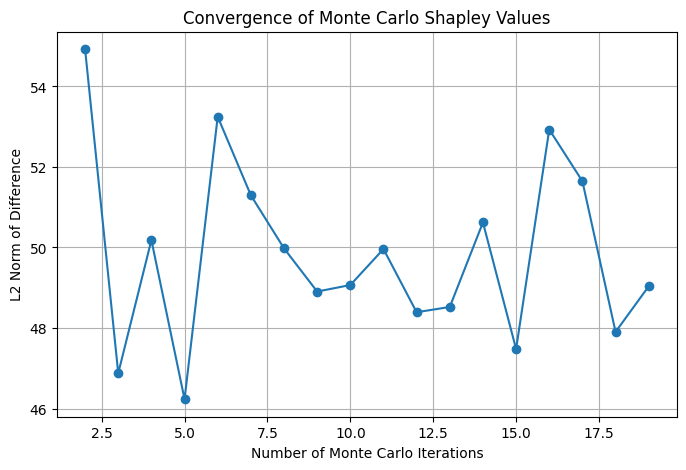

In [17]:
# Plot the residuals
plt.figure(figsize=(8, 5))
plt.plot(n_itters, residuals, marker='o', linestyle='-')
plt.xlabel('Number of Monte Carlo Iterations')
plt.ylabel('L2 Norm of Difference')
plt.title('Convergence of Monte Carlo Shapley Values')
plt.grid(True)
plt.show()

1. **Very noisy at first**  
   - With only 2–3 samples, the error is large and jumps up and down a lot.  
   - This is because each new random ordering can give a very different result.

2. **Error slowly goes down**  
   - As you increase to 7–12 samples, the difference tends to be a bit smaller on average.  
   - That means more samples help you get closer to the true value.

3. **Still bouncing around at ~20 samples**  
   - Even at 18–19 samples, the error is still around 49–53.  
   - You’d need many more samples (hundreds or thousands) to see the line really flatten out.


### Section 3 | Using the SHAP library to analyze the Titanic dataset  

In this section, we will use fast approximate methods to calculate Shapley values and analyze the Titanic dataset at different levels of granularity. By the end of this section, you should be able to interpret a wide variety of built-in SHAP plotting functions.

**3.1| Use the SHAP library to calculate the Shapley value for all features and instances of the Titianic dataset**

In [18]:
# Load the data
data = pd.read_csv('../data/titanic_data.csv')

# Load the model
model = joblib.load('../models/titanic_model.pkl')

data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,2.0
1,1,0,38.0,1,0,71.2833,0.0
2,3,0,26.0,0,0,7.9250,2.0
3,1,0,35.0,1,0,53.1000,2.0
4,3,1,35.0,0,0,8.0500,2.0


In [19]:
# Calculate the SHAP values

# YOUR CODE HERE

X = data.copy()

# Create a fast TreeExplainer (for tree‐based models)
explainer = shap.TreeExplainer(model)

# Compute Shapley values for every row and feature
shap_values = explainer.shap_values(X)

**3.2 | Identify and Rank the Importance of Each Feature for the Model's Decisions, Plot and Discuss the Results**

Evaluating the importance of features is straightforward. Features with larger absolute Shapley values are more important for the model's decisions. Therefore, the feature's global importance is calculated as

$$
I_j = \frac{1}{n}\sum^n_{i=1}|\phi^{(i)}_j|.
$$

You can either calculate this manually and generate a bar plot, or use the SHAP built-in summary plotting function with `plot_type='bar'`.

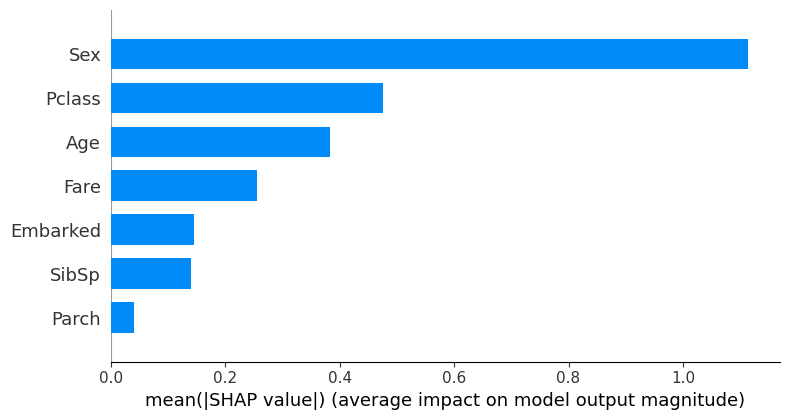

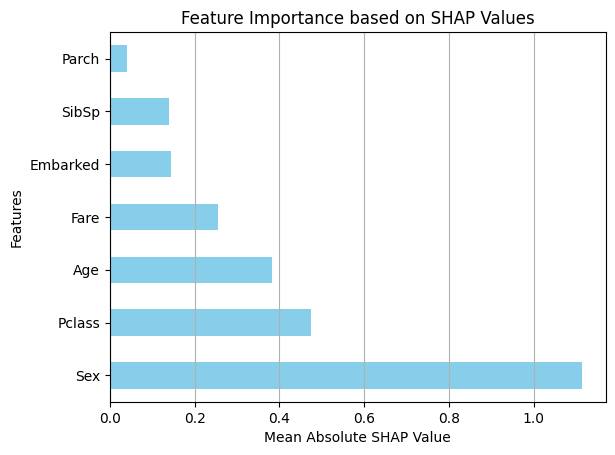

In [20]:
# Identify feature importance using the SHAP bar plot 

# Your CODE HERE

shap.summary_plot(shap_values, X, plot_type='bar')

# Compute I_j = mean absolute Shapley value for each feature
mean_abs_phi = np.mean(np.abs(shap_values), axis=0)
feat_importance = pd.Series(mean_abs_phi, index=X.columns).sort_values(ascending=False)

# Plot
plt.figure()
feat_importance.plot(kind='barh', color='skyblue')
plt.title('Feature Importance based on SHAP Values')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.grid(axis='x')
plt.show()

The bar plot indicates that the factors contributing most to survival are Sex, Class, and Age. However, this information does not show the relationship between the predicted outcome and the feature values. For a more detailed view, we can use a SHAP summary (beeswarm) plot.

**3.3 | Use SHAPs built in summary/beeswarm plot and interpret the results**

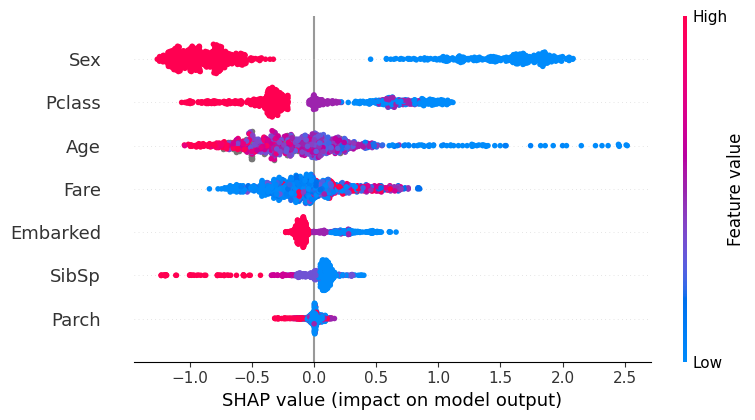

In [21]:
# Plot a bee swarm plot for the SHAP values

# YOUR CODE HERE

# This will create the beeswarm plot
shap.summary_plot(shap_values, X)

When interpreting the summary plot, consider the following points:

- **Vertical Axis**: Indicates feature importance, which corresponds to the same order as the bar plot.
- **Horizontal Position**: Shows whether the effect of a feature value is associated with a higher or lower prediction.
- **Color**: Represents whether that feature's value is high or low for that particular instance of the dataset.
- **Vertical Dispersion (Thickness)**: Is a proxy for the amount of feature interaction. Thick areas suggest a high interaction or dependence with other features.

**What the Beeswarm Plot Shows**

- **Each dot** = one passenger, one feature.  
- **Left vs. right**  
  - Left (negative SHAP) → pushes model toward “didn’t survive”  
  - Right (positive SHAP) → pushes model toward “survived”  
- **Color**  
  - Blue = low feature value  
  - Red = high feature value

**Main Points**

1. **Sex (gender) is most important**  
   - Red dots on the left = males, lower chance to survive  
   - Blue dots on the right = females, higher chance to survive  

2. **Passenger class matters**  
   - 3rd class (red) → lower survival  
   - 1st class (blue) → higher survival  

3. **Age and Fare also help**  
   - Older (red) → lower survival  
   - Younger (blue) → higher survival  
   - Low fare (blue) → lower survival  
   - High fare (red) → higher survival  

4. **Other features (Embarked, SibSp, Parch)**  
   - Dots are close to zero and mixed colors → small effect  

**Takeaway**

- The model mostly looks at **gender**, then **class**, then **age** and **fare**.  
- Things like where someone embarked or how many relatives they had only tweak the result a little.  

**3.4 | Compare a PDP plot for `Age` with a SHAP dependancy plot. What additional information do we gain?**  

In [22]:
# Calculate the PDP curve for a single feature

# Select the feature to compare
feature_name = 'Age'

# Prepare data
data_sorted = data.sort_values(by=feature_name)  # Order the rows of the data according to the value of the target feature
feature_values = data_sorted[feature_name]  # Get the target feature values
feature_values_unique = feature_values.unique()  # Get the unique values of the target feature
xax = feature_values_unique.copy()  # These are the x-axis values for the PDP curve

# Calculate PDP curve
pdp_curve = []  # List to store the PDP curve

# YOUR CODE HERE

for val in xax:
    temp = X.copy()
    temp[feature_name] = val
    dmat = xgb.DMatrix(temp)               # wrap for XGBoost
    preds = model.predict(dmat)            # now returns an array
    pdp_curve.append(preds.mean())
        

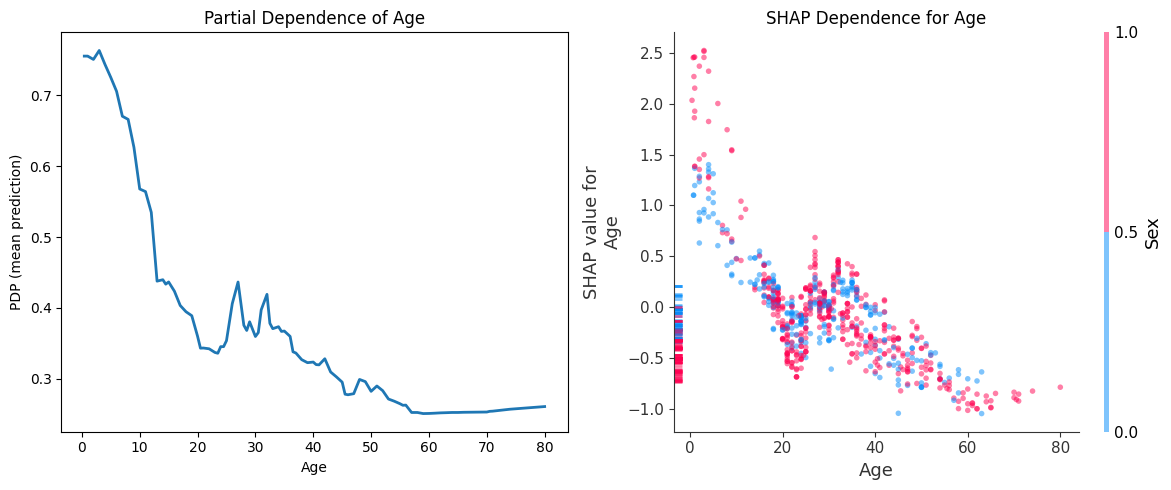

In [23]:
# Plot SHAP values and PDP curve on the same plot but with different y-axes

# YOUR CODE HERE
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Left: PDP
axs[0].plot(xax, pdp_curve, linewidth=2)
axs[0].set_xlabel('Age')
axs[0].set_ylabel('PDP (mean prediction)')
axs[0].set_title('Partial Dependence of Age')

# Right: SHAP dependence
shap.dependence_plot(
    feature_name,
    shap_values,
    X,
    ax=axs[1],
    show=False,
    alpha=0.5
)
axs[1].set_title('SHAP Dependence for Age')

plt.tight_layout()
plt.show()

**Left: Partial Dependence Plot (PDP)**
- Shows the **average** survival prediction if everyone was that age.  
- You can see that as **age increases**, the average chance of survival **goes down**.

**Right: SHAP Dependence Plot**
- Each dot is one passenger’s “age effect.”  
- **Blue** dots = female, **pink** = male.  
- Even at the same age, some dots are above or below zero—meaning other factors change how age matters.

**Summary**
1. **Big picture vs. personal story**  
   - PDP = overall trend (older → lower survival).  
   - SHAP = how age actually helped or hurt each person’s prediction.

2. **Mix with other info**  
   - SHAP shows that at the same age, men and women (and people in different classes) get different survival boosts or penalties.

3. **When to use which**  
   - Use PDP for a simple average view.  
   - Use SHAP for a detailed, per-person view that shows interactions.

**3.5 | Plot a SHAP feature dependence plot for 'Age' with interaction visualization for the passengers' Sex. Interpret the results**

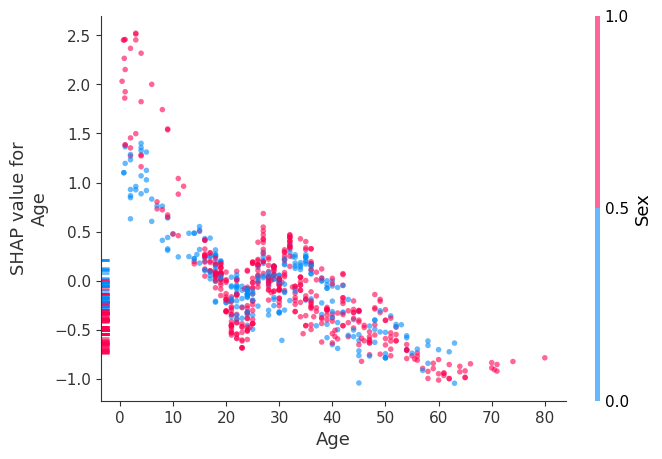

In [24]:
# Plot a SHAP feature dependence plot with interaction visualization

# YOUR CODE HERE

shap.dependence_plot(
    'Age',
    shap_values,
    X,
    interaction_index='Sex',
    show=False,
    alpha=0.6
)

**What this plot shows**

- **Each dot** = one passenger’s “age effect” on survival.  
- **X-axis (Age)** = how old they are.  
- **Y-axis (SHAP value for Age)** = how much age alone moves the prediction (above zero = helps survival, below zero = hurts).  
- **Color** = gender (blue = female, pink = male).

**Easy takeaways**

1. **Kids do better**  
   - Almost all dots under age 10 are above zero → being a child gives a survival boost.  

2. **Growing older hurts**  
   - After around age 20, most dots fall toward or below zero → age starts lowering survival odds.  

3. **Men vs. women**  
   - Pink (men) dots are usually higher than blue for kids (boys get an even bigger boost)  
   - Pink dots dip lower than blue for adults and seniors (age hurts men more than women).

**Why it matters**

- You see the **average trend** (young → good, old → bad) **and** the **gender twist** (boys get a bigger lift, men take a bigger hit) all in one plot.  
- This helps you understand not just “what age does” on average, but **how it works differently** for men and women.  

**3.6 | Remove all the individual effects of the features and plot only the pure interaction between 'Age' and 'Class'**  

Formerly the SHAP library will is calculate

$$
\phi_{i, j}=\sum_{S \subseteq \backslash\{i, j\}} \frac{|S|!(M-|S|-2)!}{2(M-1)!} \delta_{i j}(S),
$$

where $i\neq j$, and

$$
\delta_{i j}(S)=\hat{f}_x(S \cup\{i, j\})-\hat{f}_x(S \cup\{i\})-\hat{f}_x(S \cup\{j\})+\hat{f}_x(S).
$$

In other words we subtract the main effects by accounting for individual feature effects.

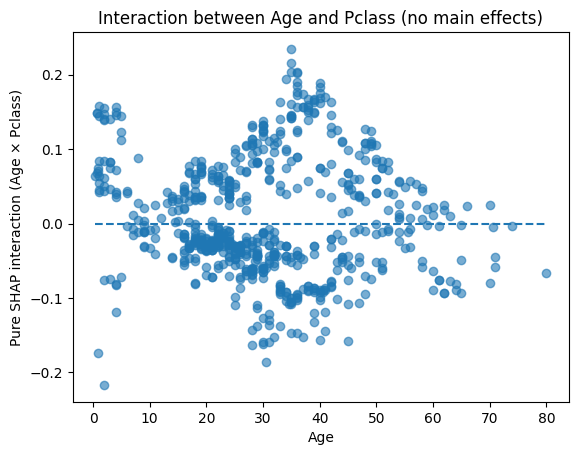

In [25]:
# Calculate the pure SHAP interaction values (One M times M matrix for each instance)

# YOUR CODE HERE
# 1) Compute full SHAP interaction values
explainer = shap.TreeExplainer(model)
shap_interaction_values = explainer.shap_interaction_values(X)
# shap_interaction_values shape: [n_samples, n_features, n_features]

# 2) Find the column indices for Age and Pclass
age_idx   = X.columns.get_loc('Age')
class_idx = X.columns.get_loc('Pclass')

# 3) Extract the pure interaction term for each passenger
age_class_interaction = shap_interaction_values[:, age_idx, class_idx]

# 4) Plot Age vs. the pure interaction SHAP value
plt.figure()
plt.scatter(X['Age'], age_class_interaction, alpha=0.6)
plt.xlabel('Age')
plt.ylabel('Pure SHAP interaction (Age × Pclass)')
plt.title('Interaction between Age and Pclass (no main effects)')
plt.hlines(0, xmin=X['Age'].min(), xmax=X['Age'].max(), linestyles='dashed')
plt.show()

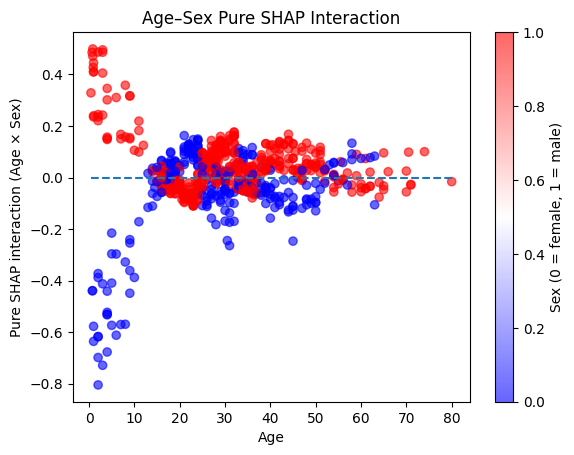

In [26]:
#Plot the pure SHAP interaction values for the Age and Sex features

# YOUR CODE HERE

sex_idx = X.columns.get_loc('Sex')

# 3) Extract the pure interaction term for Age×Sex
age_sex_interaction = shap_interaction_values[:, age_idx, sex_idx]

# 4) Scatter plot: Age vs. pure Age×Sex interaction, colored by Sex
plt.figure()
sc = plt.scatter(
    X['Age'],
    age_sex_interaction,
    c=X['Sex'],
    cmap='bwr',
    alpha=0.6
)
plt.xlabel('Age')
plt.ylabel('Pure SHAP interaction (Age × Sex)')
plt.title('Age–Sex Pure SHAP Interaction')
plt.hlines(0, X['Age'].min(), X['Age'].max(), linestyles='dashed')
plt.colorbar(sc, label='Sex (0 = female, 1 = male)')
plt.show()

- **What you see**  
  - Each dot is one passenger.  
  - **X-axis** = Age.  
  - **Y-axis** = pure interaction effect of Age and Sex (after removing each one’s individual effect).  
  - **Color** = gender (blue = female, red = male).  

- **Easy takeaways**  
  1. **Big interaction for little kids**  
     - Under ~10 years old, the dots spread out a lot.  
     - **Red dots above zero** → boy-kids get an extra survival boost when you account for both age and sex together.  
     - **Blue dots below zero** → girl-kids get slightly less boost than the main effects would suggest.  
  2. **Mostly flat for adults**  
     - From about age 20 onward, dots hover close to zero.  
     - This means that for grown-ups, age and sex mostly add up without extra teamwork.  
  3. **Teen years in between**  
     - Around ages 10–20, you see some red dots just above zero and blue dots just below—boys still get a bit more help from age, girls a bit less.  

- **Summary:**  
  - The plot shows where age and gender really **interact** (work together) beyond their separate effects.  
  - It tells us: **kids’ survival odds** depend on a special age-sex combo, but **adults** see age and sex act almost independently.  

**3.7 | Local Shapley Explanations**

Plot a waterfall plot for three individuals: the one most likely to survive according to the model, the one least likely to survive, and an average passenger. Interpret the results.

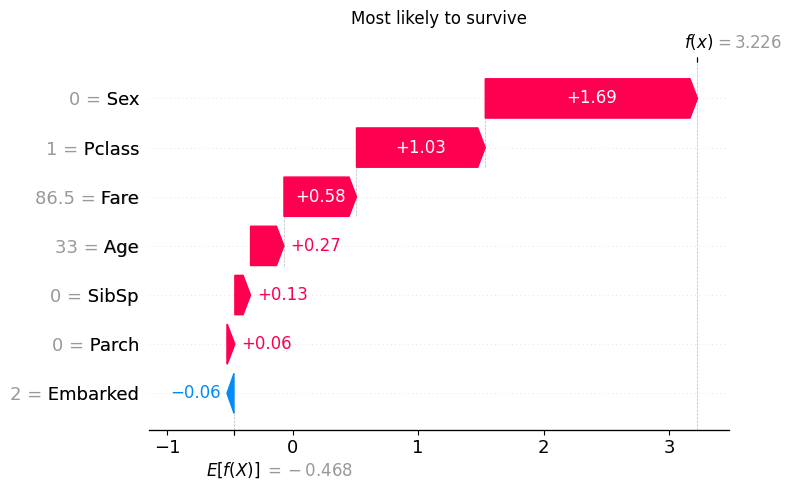

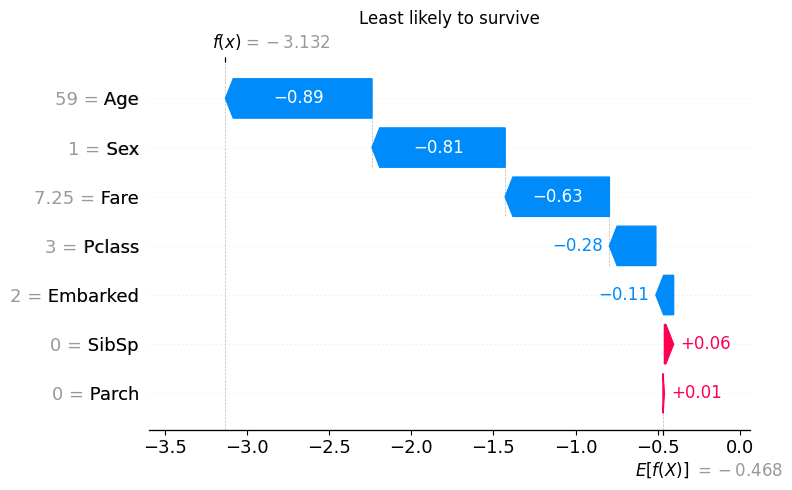

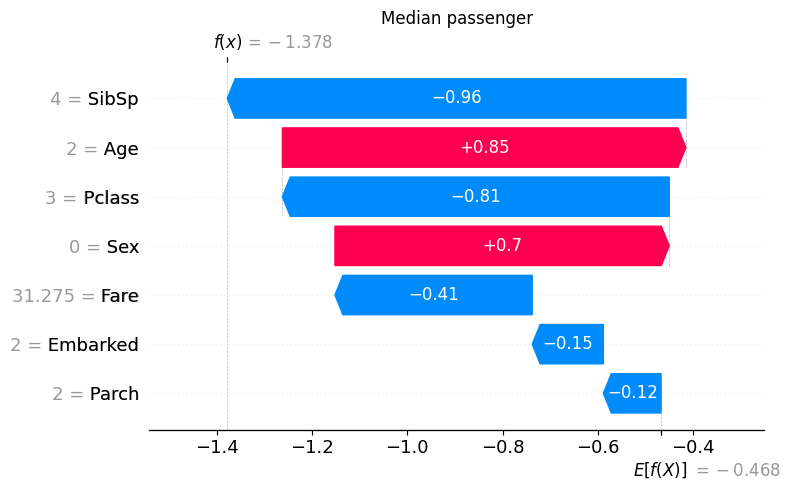

In [27]:
# 1) Get SHAP values and base value
explainer = shap.TreeExplainer(model)
shap_vals_all = explainer.shap_values(X)
if isinstance(shap_vals_all, list):
    # binary classification: take the SHAP values for the "survived" class
    shap_vals = shap_vals_all[1]
    base_value = explainer.expected_value[1]
else:
    shap_vals = shap_vals_all
    base_value = explainer.expected_value

# 2) Compute survival probabilities with XGBoost's predict (returns P(class=1) for binary:logistic)
dmat = xgb.DMatrix(X)
probs = model.predict(dmat)

# 3) Find indices: highest, lowest, and median survival probability
idx_most  = np.argmax(probs)
idx_least = np.argmin(probs)
idx_med   = np.argsort(probs)[len(probs) // 2]

# 4) Plot a waterfall for each selected passenger
for idx, label in zip(
    [idx_most, idx_least, idx_med],
    ['Most likely to survive', 'Least likely to survive', 'Median passenger']
):
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_vals[idx],
            base_values=base_value,
            data=X.iloc[idx]
        ),
        show=False
    )
    plt.title(label)
    plt.tight_layout()
    plt.show()

Each waterfall plot represents a single point on the beeswarm plot. These plots provide local explanations on a per-instance basis, allowing us to precisely determine the factors contributing to or detracting from an individual's survival probability. The individual most likely to survive is a high-paying, middle-aged, first-class female passenger, while the lowest survival probability is assigned to a low-paying, elderly, third-class male passenger.

### Section 4 | Determine the decision making process of the mystery model  

Here you should have developed all the tools necessary to quickly identify the mechanism of decision for this simple model.  

In [28]:
# Load the mystery data 
X = pd.read_csv('../data/mystery_data.csv')

# Load the mystery model
model = joblib.load('../models/mystery_model.pkl')

X.head()

,Feature1,Feature2
0,1,1
1,1,1
2,1,1
3,1,0
4,0,1


In [30]:
# YOUR CODE HERE
# Get predictions
X['prediction'] = model.predict(X)

# Summarize by input combination
decision_table = X.groupby(['Feature1', 'Feature2'])['prediction'].agg(['mean', 'count']).reset_index()
decision_table.columns = ['Feature1', 'Feature2', 'Predicted_Class', 'Num_Samples']

print(decision_table)

   Feature1  Feature2  Predicted_Class  Num_Samples
0         0         0              0.0          111
1         0         1              1.0           86
2         1         0              1.0          112
3         1         1              0.0           91


**Mystery Model Decision Rule**

When we look at all four possible inputs of (Feature1, Feature2), the model always predicts:

| Feature1 | Feature2 | Prediction |
| :-------: | :-------: | :--------: |
|     0     |     0     |      0     |
|     0     |     1     |      1     |
|     1     |     0     |      1     |
|     1     |     1     |      0     |

In plain English:

- If both features are the same (both 0 or both 1), the model predicts **0**.  
- If the features are different (one is 0 and the other is 1), the model predicts **1**.  

This is exactly the **exclusive-or (XOR)** function:

> **Are Feature1 and Feature2 different?**  
> - If **yes**, output **1**.  
> - If **no**, output **0**.